In [1]:
%matplotlib inline
from __future__ import print_function
import pandas as pd

# Module 2: Communication between Python and R using rpy2

## Python vs R
* Most websites/books frame Python and R as adversarial languages
* Posts like "Data Science Wars: R vs Python" and "R vs Python, The Great Debate."
* Easily devolves into a flame war, but the argument is made that data scientists/statisticians generally prefer R, whereas software developers generally prefer Python
* Safe to say that R has a huge head start on statistical methods

## Python *and* R
* Rather than choose sides, the idea behind the package `rpy2` is intercommunication between Python and R.
* There exists an R counterpart package (rPython) that calls Python from R
* Currently, `rpy2` is most often used to access R statistical functionality that doesn't yet exist in Python

## rpy2 requirements and features
* Both Python and R need to be installed
* Can "source" R scripts and import R libraries and functions
* Integrates nicely with Jupyter notebooks
* Integrates nicely with pandas DataFrames
* Notoriously tricky to get set up on Windows machines (need to set environmental variables)

## Basic use of rpy2
* Main module to use with `rpy2` to use is `robjects`
* Within `robjects`, the object named `robjects.r` is the entry point to the embedded R process.  It can directly reference R vectors and functions.

In [3]:
import rpy2.robjects as robjects

# Vector
pi = robjects.r.pi
print(pi)

# Function
seq = robjects.r.seq
print(seq(1, 5))

[1] 3.141593

[1] 1 2 3 4 5



## Transforming Python objects to R objects
Lists in Python need to be converted into R vectors before being used in functions.  `rpy2` provides functionality for this conversion (e.g. `IntVector`, `FloatVector`, `StrVector`)

In [7]:
# Convert python list to R vector
py_list = [3, 4, 5]
r_vec = robjects.IntVector(py_list)
print('Python object:', py_list)
print('R object:', r_vec)
print('Round tripped Python object:', list(r_vec))

Python object: [3, 4, 5]
R object: [1] 3 4 5

Round tripped Python object: [3, 4, 5]


In [5]:
# Convert python list to R vector
py_list = ['bob', 'sue', 'ted']
r_vec = robjects.StrVector(py_list)
print('Python object:', py_list)
print('R object:', r_vec)

Python object: ['bob', 'sue', 'ted']
R object: [1] "bob" "sue" "ted"



In [6]:
# Creating a matrix by transformation
v = robjects.FloatVector([1.1, 2.2, 3.3, 4.4, 5.5, 6.6])
m = robjects.r['matrix'](v, nrow = 2)
print(m)

     [,1] [,2] [,3]

[1,]  1.1  3.3  5.5

[2,]  2.2  4.4  6.6



## Pandas DataFrame to R dataframe

In [8]:
# Set up the packages needed to convert between pandas and R dataframes
import pandas as pd
from rpy2 import robjects
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

# Read in CSV data to a pandas DataFrame
iris_df = pd.read_csv('iris.csv')

# Convert to R dataframe
r_dataframe = pandas2ri.py2ri(iris_df)

print('Pandas object:')
print('Type:', type(iris_df))
print(iris_df.head())
print('-' * 50)
print('R object:')
print(robjects.r['class'](r_dataframe))
print(robjects.r['head'](r_dataframe))

Pandas object:
Type: <class 'pandas.core.frame.DataFrame'>
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
--------------------------------------------------
R object:
[1] "data.frame"

  sepal_length sepal_width petal_length petal_width species

0          5.1         3.5          1.4         0.2  setosa

1          4.9         3.0          1.4         0.2  setosa

2          4.7         3.2          1.3         0.2  setosa

3          4.6         3.1          1.5         0.2  setosa

4          5.0         3.6          1.4         0.2  setosa

5          5.4         3.9          1.7         0.4  setosa



In [10]:
# Getting the R data.frame back as a pandas DataFrame
return_df = pandas2ri.ri2py(r_dataframe)
print('Type:', type(return_df))
print(return_df.head())

Type: <class 'pandas.core.frame.DataFrame'>
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


## Creating R functions as strings

In [11]:
# Create a function in the R namespace called f
# Remember that the r object is the R process itself
robjects.r("""
  # create a function `f`
  f <- function(r) {
      2 * pi * r
  }
""")

# Now get a Python reference to the R function we just created
r_f = robjects.r['f']

# Print the actual function - now living in R's namespace
print(r_f)

function(r) {

      2 * pi * r

  }



In [12]:
# Call this function - returned as vector of length 1
print(r_f(10), type(r_f(10)))

[1] 62.83185
 <class 'rpy2.robjects.vectors.FloatVector'>


In [13]:
# Get reference to the scalar value by indexing
print(r_f(10)[0], type(r_f(10)[0]))

62.8318530718 <type 'float'>


## Importing packages

You can alias R packages to Python names using the `importr` function

In [14]:
from rpy2.robjects.packages import importr
stats = importr('stats')
print(stats.rnorm(5))

[1]  0.26804113 -1.41936200 -0.16056392 -1.58682554 -0.01140182



*Gotcha*: R functions/variables with `.` in names - generally replaced with `_`

In [15]:
# R syntax: rank(0, na.last = TRUE)
base = importr('base')
v = robjects.IntVector([4, 2, 3])
print(base.rank(v, na_last = True))

[1] 3 1 2



## Installing packages directly from rpy2 using CRAN

In [16]:
# imports
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

# import R's utility package
utils = rpackages.importr('utils')

# Set up CRAN mirror
utils.chooseCRANmirror(ind=1)

# Choose which package names to install
package_names = ('ggplot2',)

# Verify that it's not already installed, then install list of packages
names_to_install = [x for x in package_names if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

## Sourcing files and running code
If you have existing code that you want to call from Python, this is a great way to do it

In [17]:
# Sample script
SAMPLE_SCRIPT = './rescale_vector.r'

# Source the script
# This defines a function called 'rescale01' in R's namespace
robjects.r.source(SAMPLE_SCRIPT)

# Create an R vector to pass
int_vector = robjects.IntVector(range(0, 11))

# Call the function through r object
norm_vector = robjects.r.rescale01(int_vector)

# Print this norm_vector (as R object)
print(norm_vector)

# Convert to Python list
print(list(norm_vector))

 [1] 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


## R "magic"
* IPython (the python kernel in Jupyter) has the concept of magics
* From "Python Data Science Handbook" (Jake VanderPlas (O'Reilly Media, 2016))
> "... magic commands are designed to succinctly solve various common problems
> in standard data analysis. Magic commands come in two flavors: line magics,
> which are denoted by a single % prefix and operate on a single line of
> input, and cell magics, which are denoted by a double %% prefix and
> operate on multiple lines of input.
* `rpy2` provides two magic commands: `%R` (line magic) and `%%R` (cell magic) that allow to user to run R from within Jupyter IPython kernel
* Need to activate magic with this line: `%load_ext rpy2.ipython`
* All R graphics work should probably use these magics (due to some IPython-specific bugs in rpy2)

## R "magic" - setup

In [18]:
# This will look like you get an error - known issue with rpy2/ipython
%load_ext rpy2.ipython

In [19]:
# Ensure we have %R and %%R loaded
%lsmagic

Available line magics:
%R  %Rdevice  %Rget  %Rpull  %Rpush  %alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%R  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl  %%prun  %%p

## R "magic" - examples (cont.)

#### Examples of line magic (%R)

In [20]:
# Running an R function
%R sum(seq(1, 5))

array([15])

In [21]:
# Requiring a library
%R require(ggplot2)

array([1])

## R "magic" - examples (cont.)

#### Example of cell magic (%%R)

In [22]:
%%R
require(base)
x <- c(3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5)
# For some reason, this is printing to console
rank(x, na.last = TRUE)

## Using ggplot2 within Jupyter
ggplot2 (a common graphics libary in R) provides a nice graphics library and is familiar to many R users.  Graphics from ggplot2 can be directly rendered within Jupyter

In [23]:
# Ensure we've loaded the magic extension and required ggplot2
%load_ext rpy2.ipython
%R require(ggplot2)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array([1])

In [26]:
# Load in pandas and make a sample dataframe
import pandas as pd 
df = pd.DataFrame({'Alphabet': ['a', 'b', 'c', 'd','e', 'f', 'g', 'h','i'],
                   'A': [4, 3, 5, 2, 1, 7, 7, 5, 9],
                   'B': [0, 4, 3, 6, 7, 10,11, 9, 13],
                   'C': [1, 2, 3, 1, 2, 3, 1, 2, 3]})

We can now pass the pandas dataframe from Python to the R cell magic using the `-i` (input) flag.  Once we're within the R environment, we only need to issue the `ggplot` command.

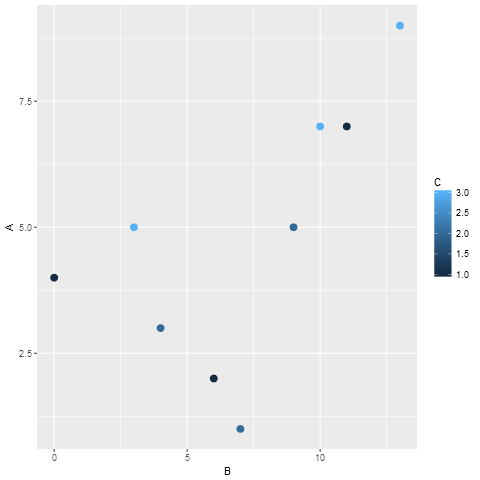

In [28]:
%%R -i df
# Plot the DataFrame df
ggplot(data=df) + geom_point(size=3, aes(x=B, y=A, color=C))

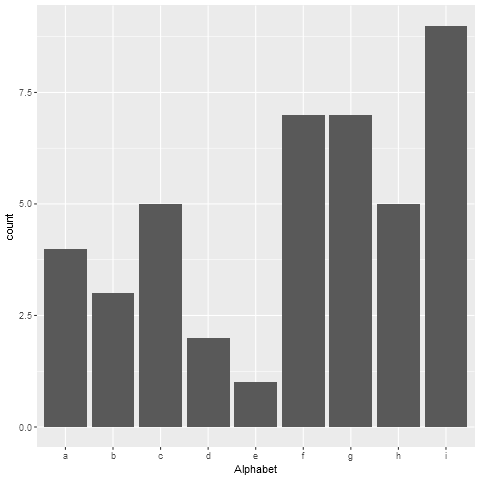

In [29]:
%%R -i df
# Plot the DataFrame df
ggplot(data=df, aes(Alphabet)) + geom_bar(aes(weight=A))

## Exercises

### Exercise 1: Running a simple linear regression using `lm` within R

We're going to run a simple linear model using R's functionality, but otherwise evaluating our results within Python.  Simple linear regression is definitely something Python can do on its own, but we want to practice getting data in and out of R using `rpy2`.  

We are going to work with the `iris` dataset - a sample dataset of 150 measurements of iris flowers in three different species.  This file is stored as `iris.csv` in your folder.  Using pandas, import the iris dataset as `iris_df`.  Take a look at the first five lines of this dataset.

In [70]:
# Read in the iris dataset to a pandas DataFrame
import pandas as pd
iris_df = pd.read_csv('iris.csv')
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Now that we have our dataframe, let's preview it using R's built-in `plot` function.  This will plot out a scatterplot matrix of all variables in this dataset.  To solve this, you'll need to:
* use R **cell** magic
* bring in the `iris_df` as an input variable
* use the `plot` function on the passed dataframe

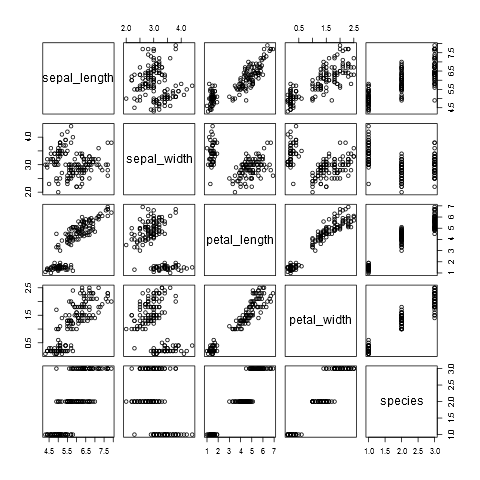

In [74]:
%%R -i iris_df
# Simply plot the variables in relation to one another
plot(iris_df)

We can see that there are some simple linear relationships between paired variables within this dataset.  We'll try to predict `petal_width` as a function of `petal_length`.  We are going to do this same regression with two different calling syntaxes - one using `robjects` and one using cell magic.

For the first method, we need to have access to the R `lm` function which is part of the `stats` library.  Using what you know about importing R libraries in `rpy2`, create a Python variable called `stats` that imports the R `stats` library.  

In [93]:
from rpy2.robjects.packages import importr
stats = importr('stats')

Now that we have access to this libary, we want to call its `lm` method with the formula `petal_width ~ petal_length` and passing it `iris_df` as its data keyword.  Call the output of this model `model_1` and simply print it. (Note that the output from `rpy2` is much more verbose than R's version

In [95]:
model_1 = stats.lm('petal_width ~ petal_length', data=iris_df)
print(model_1)



Call:

(function (formula, data, subset, weights, na.action, method = "qr", 

    model = TRUE, x = FALSE, y = FALSE, qr = TRUE, singular.ok = TRUE, 

    contrasts = NULL, offset, ...) 

{

    ret.x <- x

    ret.y <- y

    cl <- match.call()

    mf <- match.call(expand.dots = FALSE)

    m <- match(c("formula", "data", "subset", "weights", "na.action", 

        "offset"), names(mf), 0L)

    mf <- mf[c(1L, m)]

    mf$drop.unused.levels <- TRUE

    mf[[1L]] <- quote(stats::model.frame)

    mf <- eval(mf, parent.frame())

    if (method == "model.frame") 

        return(mf)

    else if (method != "qr") 

        warning(gettextf("method = '%s' is not supported. Using 'qr'", 

            method), domain = NA)

    mt <- attr(mf, "terms")

    y <- model.response(mf, "numeric")

    w <- as.vector(model.weights(mf))

    if (!is.null(w) && !is.numeric(w)) 

        stop("'weights' must be a numeric vector")

    offset <- as.vector(model.offset(mf))

    if (!is.null(offset))

Lastly, for this first method, we want to extract the coefficients of this model so that we can compare it against our second method's results.  In R, one way to retrieve the coefficients is like this: `model_1[['coefficients']]`.We need to use the `rx` function on `model_1` to get its coefficients.  The `rx2` function is `rpy2`'s shorthand for the double bracket ('\[\[') operator in R.  Save the coefficients as `coeff_1` and convert it to a Python list.

In [125]:
coeff_1 = list(model_1.rx2('coefficients'))
print(coeff_1)

[-0.36651404521672737, 0.41641913228540106]


Now, on to our second method.  We'll program in R directly using R's cell magic.  This is a much more terse way of performing the operation but there are a number of considerations.  It will be tricky to get this full syntax correct.
* Use R cell magic
* Pass the `iris_df` as the input data frame
* On the R cell magic line, also designate the output with the `-o` flag and set it equal to `coeff_2`
* In R, the `lm` call will be `lm(petal_width ~ petal_length, data=iris_df)`
* Also in R, you can extract the coefficients from the `lm` using `$coefficients`
* Set all this equal to the ouput variable `coeff_2`

In [126]:
%%R -i iris_df -o coeff_2
coeff_2 <- lm(petal_width ~ petal_length, data=iris_df)$coefficients

Verify that `coeff_1` and `coeff_2` match by printing both.  Note that technically `coeff_2` is a numpy array rather than a list.

In [130]:
print(coeff_1)
print(coeff_2)

[-0.36651404521672737, 0.41641913228540106]
[-0.36651405  0.41641913]


### Exercise 2: Create an external R function and source it using `rpy2`

In this exercise, we'll create a simple R function in an external text editor (Notepad++ works well) and save it to our working directory.  We will source this R file and call this function from `rpy2`.  

To start, open Notepad++ (or your favorite text editor) and copy these lines into it:
```
vector_adder <- function(v, add_amount) {
  v + add_amount
}
```
and save this file in the '2-communication-with-r' folder as `vector_adder.r`.  This is a very simple script that will add a set value to each value in a vector and return that vector.

Once you've done this, look back to the overview section on how to source an R script.  Copy this section of code and paste into the cell below.  You'll want to make a few modifications to the code:
* Change the SAMPLE_SCRIPT to point to your new script
* Change the vector that you're going to pass to be numbers from 10 to 20
* Call the function `vector_adder` with two arguments - your vector and the value 5
* Change the name of `norm_vector` to `added_vector`
* Print both `added_vector` and the Python list repesentation of it

In [4]:
# Sample script
SAMPLE_SCRIPT = './vector_adder.r'

# Source the script
# This defines a function called 'vector_adder' in R's namespace
robjects.r.source(SAMPLE_SCRIPT)

# Create an R vector to pass
int_vector = robjects.IntVector(range(10, 21))

# Call the function through r object
added_vector = robjects.r.vector_adder(int_vector, 5)

# Print this added_vector (as R object)
print(added_vector)

# Convert to Python list
print(list(added_vector))

 [1] 15 16 17 18 19 20 21 22 23 24 25

[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


Look at the following output.  Use a Python for loop along with the code you just wrote to try to replicate this output

In [6]:
# It's not necessary to re-source the script or recreate the int_vector object
for add_amount in range(1, 6):
    # Call the function through r object
    added_vector = robjects.r.vector_adder(int_vector, add_amount)
    
    # Convert to Python list
    print(list(added_vector))

[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


```
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
```

### Exercise 3: Create ggplot graphics using R magic

In this final exercise, we'll create a pandas dataframe and progressively build up a nicer looking ggplot output.  This is a bit of a ggplot tutorial (not Python), but there is a project to port ggplot to Python (http://ggplot.yhathq.com/), so this will not be wasted effort.  However, for this exercise, we'll use R's `ggplot2` library.

As before, load in the iris dataset into a pandas DataFrame from the `iris.csv` file.  Call it `iris_df`.

In [23]:
iris_df = pd.read_csv('iris.csv')

Using R cell magic, bring this data into R and plot the most basic ggplot, just using `ggplot(iris_df, aes(petal_length, petal_width)`.  This will set up the graphing axes.

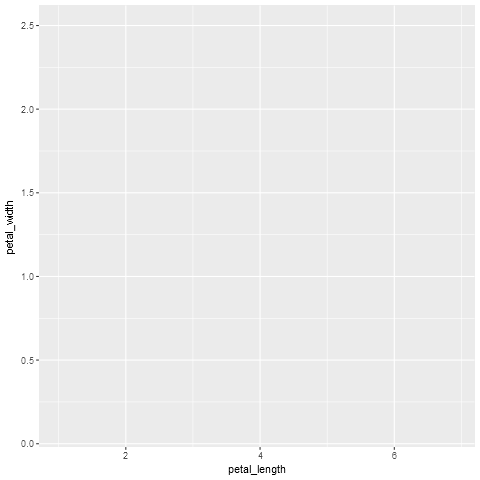

In [20]:
%%R -i iris_df
ggplot(iris_df, aes(petal_length, petal_width))

Now, add the data points by "adding" a `geom_point()` call to the ggplot expression

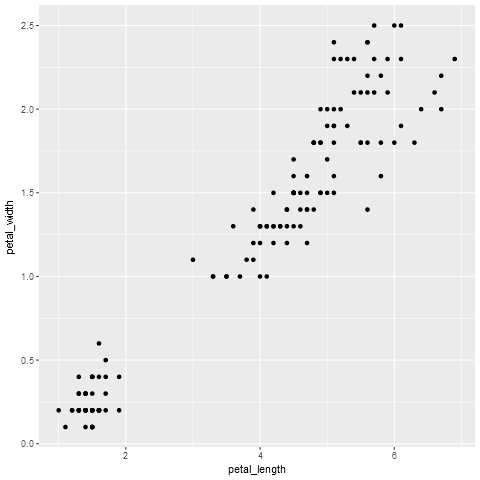

In [21]:
%%R -i iris_df
ggplot(iris_df, aes(petal_length, petal_width)) + geom_point()

Create a new 'aesthetic' (`aes`) for the dots to color the dots by species.  To create a new aesthetic, you use the `aes()` function along with the paramters that you want to have.  In this case, we want the `colour` parameter to be `species`, so our `aes` call is `aes(colour=species)`.  This whole string needs to be the parameter to `geom_point`.

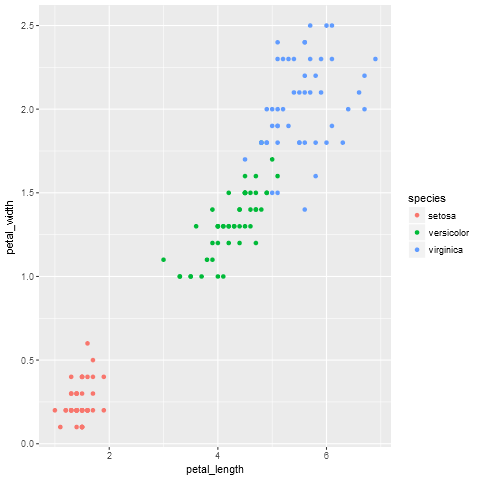

In [29]:
%%R -i iris_df
ggplot(iris_df, aes(petal_length, petal_width)) + geom_point(aes(colour=species))

Now modify the aesthetic you just created to have the size of the dot come from the `sepal_width` value.  See if you can figure out what keyword needs to be provided.

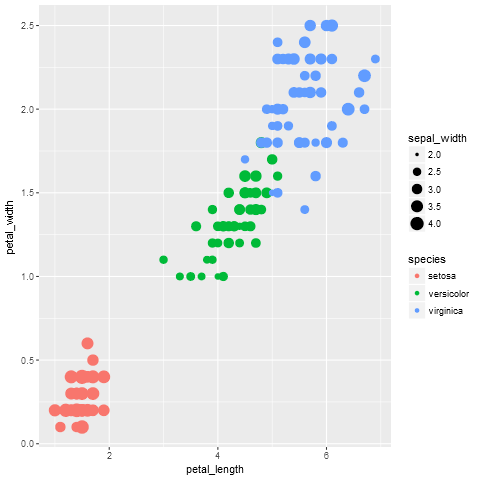

In [30]:
%%R -i iris_df
ggplot(iris_df, aes(petal_length, petal_width)) + geom_point(aes(colour=species, size=sepal_width))

Finally, you will add a line representing the linear regression fit using the additional term `geom_smooth`.  `geom_smooth` has a keyword called `method` that can be set to `'lm'` to show the least-squares regression fit.  See if you can figure out how to color the line black and make it 0.5 mm wide.

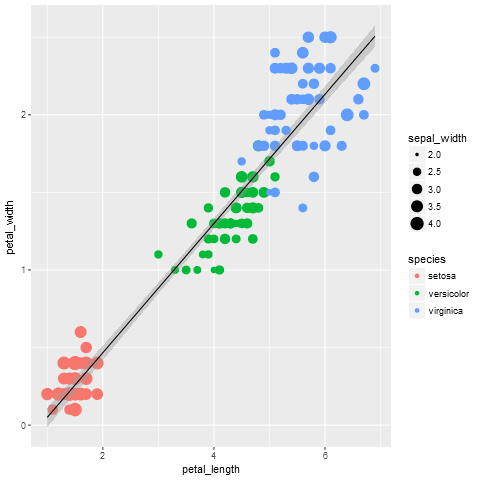

In [49]:
%%R -i iris_df
ggplot(iris_df, aes(petal_length, petal_width)) + 
  geom_point(aes(colour=species, size=sepal_width)) +
  geom_smooth(method='lm', colour='black', size=0.5)